### 統計學習初論 (Spring, 2019)
### Homework 5
#### 截止日期: 9AM, 2019/6/4

請將HTML檔上傳至Ceiba作業區。回答作業時建議使用 "三明治" 答題法。也就是說，先說明要做什麼，然後列出程式碼與結果，最後說明這些結果的意義。作業自己做。嚴禁抄襲。不接受紙本繳交，不接受遲交。請以英文或中文作答。

#### Time Series Prediction Problem
Time series prediction problem has a wide range of applications. We are going to explore this issue in this homework. To keep things simple, we are going to focus on the univariate time series, a time series with a single value in a period. 

#### Dataset: Weekly Product Sales
The dataset contains 104 weeks of training data and 39 weeks of test data. The time series is the product sales of a supermarket in a particular period. The goal is to predict sales in the test period. The training data is in "dep2train.csv" and the test data is in "dep2test.csv."

Below is the first few records of these two files:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] =120
from datetime import datetime
import pandas as pd
dep2train = pd.read_csv('dep2train.csv')
print("Head of training data:")
print(dep2train.head())
dep2test = pd.read_csv('dep2test.csv')
print("Head of test data:")
print(dep2test.head())

Head of training data:
         date  weeklySales
0  2010-02-05    123952.48
1  2010-02-12    119209.48
2  2010-02-19    121430.80
3  2010-02-26    120292.15
4  2010-03-05    113163.91
Head of test data:
         date  weeklySales
0  2011-11-04    108655.66
1  2011-11-11    106841.49
2  2011-11-18     98341.91
3  2011-11-25     97213.06
4  2011-12-02     99976.34


Let's plot the training and test data. 

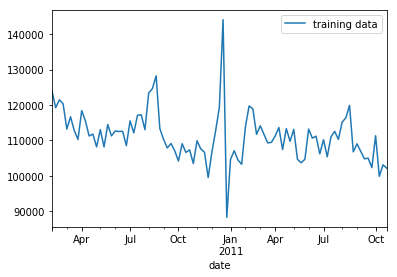

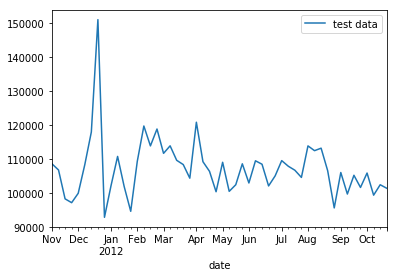

In [2]:
dep2train['date'] = pd.to_datetime(dep2train['date'])
dep2train['fold'] = 'train'
dep2test['date'] = pd.to_datetime(dep2test['date'])
dep2test['fold'] = 'test'

_ = dep2train.plot(y = 'weeklySales', x = 'date', label = 'training data')
_ = dep2test.plot(y = 'weeklySales', x = 'date', label = 'test data')

#### Measure of Prediction Accuracy
We are going to measure the prediction accuracy by mean absolute percentage error (MAPE). You should report MAPE using test data for every question. MAPE is defined as:
$ MAPE = \frac{1}{n} \sum_{i=1}^n |\frac{\hat{y}_t - y_t}{y_t}|,$ where $y_t$ is the actual value of period t and $\hat{y}_t$ is the prediction for period t. 

#### Train-test Split and Expanding Window
A common way to compute prediction error (MAPE) is to use a train-test split. We train a model M1 using the training data and use M1 to make predictions. When doing this, we apply the model and every test record independently and compute the MAPE. This approach, however, may not be reasonable because we can make predictions sequentially when applying to time series models. This is so-called the "Expanding Window" approach. That is, after making a prediction for period 1, we can include the data of period 1 into our training data. When making a prediction for period 2, the model can make use of data in period 1 together with the training data as well. We can optionally re-train the model after predicting for period 1. However, this often takes longer, and we do not re-train the model when making predictions in this homework. That is, when doing the Expanding Window approach, we train the model once using training data. To make predictions, we sequentially apply the model and include test data into training data after the test data point is used to make predictions. 

#### Implementation Restriction
You are allowed to use any Python libraries in your solution.

### Question 1 [Baseline]
(30%) Predict the sales of test data using the mean weekly sales of same week-of-year in training data. Adopt the standard train-test method to compute MAPE. For example to predict the weekly sales of 2011-11-04, we can use the sales records with similar "day of year" or "week of year" in 2010. Since 2011-11-04 is the 307-th day in 2011, you can use the 43-week (307//7) in year 2010 to predict the weekly sales of 2011-11-04. 

You should report (1) the MAPE of the test period, and (2) a plot of test data and their predicted value. 

In [3]:
import datetime
dep2train["week"]=dep2train["date"].apply(lambda x:x.strftime("%V"))
dep2test["week"]=dep2test["date"].apply(lambda x:x.strftime("%V"))

In [4]:
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [5]:
prediction=[]
for i in range(len(dep2test)):
    index=dep2test.iloc[i,3]
    value=dep2train[dep2train["week"]==index]["weeklySales"].mean()
    prediction.append(value)

In [6]:
y_true=dep2test["weeklySales"].values
y_pred=prediction
print(mean_absolute_percentage_error(y_true, y_pred))

0.043591387170382884


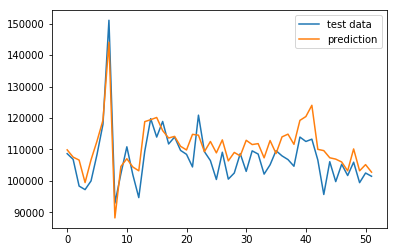

In [7]:
plt.plot(dep2test['weeklySales'],label="test data")
plt.plot(prediction,label="prediction")
plt.legend(loc='upper right')
plt.show()

### Question 2 [Random Forest]
Preidct weekly sales using Random Forest (RF). Consider the two following setting. 
* Q2.1 (15%) $y_t = f(y_{t-1}, y_{t-2}, y_{t-3}, y_{t-4})$. 
* Q2.2 (15%) $y_t = f(y_{t-1}, y_{t-2}, y_{t-3}, y_{t-4}, y_{t-52})$. 

You should use the "Expanding Window" approach when evaluating the prediction accuracy. For each setting, report the MAPE and a plot of true and predicted values. 

Q2.1 (15%) $y_t = f(y_{t-1}, y_{t-2}, y_{t-3}, y_{t-4})$. 

In [8]:
from sklearn.ensemble.forest import RandomForestRegressor

In [9]:
print(dep2train.tail())
print(dep2test.head())

         date  weeklySales   fold week
86 2011-09-30    102264.22  train   39
87 2011-10-07    111280.17  train   40
88 2011-10-14     99815.15  train   41
89 2011-10-21    103050.10  train   42
90 2011-10-28    102097.86  train   43
        date  weeklySales  fold week
0 2011-11-04    108655.66  test   44
1 2011-11-11    106841.49  test   45
2 2011-11-18     98341.91  test   46
3 2011-11-25     97213.06  test   47
4 2011-12-02     99976.34  test   48


In [10]:
train_x=[]
train_y=[]
for i in range(len(dep2train)-4):
    train_x.append(dep2train.iloc[i:i+4,1].values)
    train_y.append(dep2train.iloc[i+4,1])
    #print(train_x[i],train_y[i])

In [11]:
train_x=np.array(train_x)
print(train_x.shape)

(87, 4)


In [12]:
regr = RandomForestRegressor(n_estimators=1000, criterion='mse', random_state=1, n_jobs=-1)
regr.fit(train_x,train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [13]:
test=list(dep2test["weeklySales"].values)
start=list(dep2train.tail(4)["weeklySales"].values)
true=start+test
pred=[]
for i in range(len(dep2test)):
    prediction=regr.predict([true[i:i+4]])
    pred.append(prediction)

In [14]:
y_true=dep2test["weeklySales"].values
y_pred=pred
print(mean_absolute_percentage_error(y_true, y_pred))

0.07098921282931174


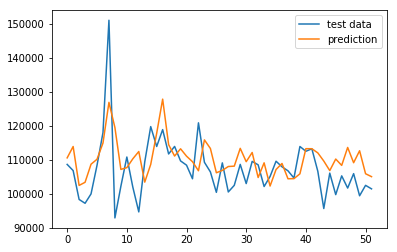

In [15]:
plt.plot(dep2test['weeklySales'],label="test data")
plt.plot(pred,label="prediction")
plt.legend(loc='upper right')
plt.show()

Q2.2 (15%) $y_t = f(y_{t-1}, y_{t-2}, y_{t-3}, y_{t-4}, y_{t-52})$. 

In [16]:
#計算哪些週出現次數為兩次
a=pd.DataFrame(dep2train["week"].value_counts())
a=a[a["week"]==2]
a=a.index
def ans(x):
    if x in a :
        return 1
    else:
        return 0
dep2train["week appear times"]=dep2train["week"].apply(ans)

In [17]:
dep2train["week appear times"].value_counts()

1    78
0    13
Name: week appear times, dtype: int64

In [18]:
#因為對於2010的資料，不會有前一年的銷售紀錄可以參考，所以待會不會放入訓練資料內
for i in range(len(dep2train)):
    if dep2train["date"][i].year==2010:
        dep2train["week appear times"][i]=0

C:\Users\POPO\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [19]:
dep2train["week appear times"].value_counts()

0    52
1    39
Name: week appear times, dtype: int64

In [20]:
dep2train[dep2train["week appear times"]==1].head()

,date,weeklySales,fold,week,week appear times
52,2011-02-04,113720.83,train,05,1
53,2011-02-11,119715.02,train,06,1
54,2011-02-18,118892.18,train,07,1
55,2011-02-25,111673.55,train,08,1
56,2011-03-04,114097.02,train,09,1


In [21]:
part=dep2train[dep2train["week appear times"]==0]
part.head()

,date,weeklySales,fold,week,week appear times
0,2010-02-05,123952.48,train,05,0
1,2010-02-12,119209.48,train,06,0
2,2010-02-19,121430.80,train,07,0
3,2010-02-26,120292.15,train,08,0
4,2010-03-05,113163.91,train,09,0


In [22]:
train_x=[]
train_y=[]
for i in range(48,len(dep2train)-4):
    a1=list(dep2train.iloc[i:i+4,1])
    a1.append(part[part["week"]==dep2train.iloc[i+4,3]]["weeklySales"].values[0])
    train_x.append(a1)
    train_y.append(dep2train.iloc[i+4,1])

In [23]:
train_x=np.array(train_x)
print(train_x.shape)

(39, 5)


In [24]:
regr = RandomForestRegressor(n_estimators=1000, criterion='mse', random_state=1, n_jobs=-1)
regr.fit(train_x,train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [25]:
test=list(dep2test["weeklySales"].values)
start=list(dep2train.tail(4)["weeklySales"].values)
pred=[]
for i in range(len(dep2test)):
    ans=dep2train[dep2train["week"]==dep2test.iloc[i,3]]["weeklySales"].values[0]
    input=list(true[i:i+4])
    input.append(ans)

    prediction=regr.predict([input])
    pred.append(prediction)

In [26]:
y_true=dep2test["weeklySales"].values
y_pred=pred
print(mean_absolute_percentage_error(y_true, y_pred))

0.06561849101444737


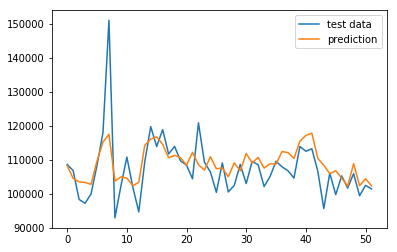

In [27]:
plt.plot(dep2test['weeklySales'],label="test data")
plt.plot(pred,label="prediction")
plt.legend(loc='upper right')
plt.show()

### Question 3 [Gaussian Process Regression]
Gaussian process regression (GPR) can be used to perform time series prediction. The input feature is simply the "week sequence number." You can construct this week sequence number from the calendar date.  Each week sequence number is paired with its weekly sales. Your Gaussian process regression should have a kernel that contains the sum of an RBF kernel (sklearn.gaussian_process.kernels.RBF), an Exp-Sine-Squared kernel (sklearn.gaussian_process.kernels.ExpSineSquared), and a White noise kernel (sklearn.gaussian_process.kernels.WhiteKernel). The RBF kernel is used to capture near-by relations, the Exp-Sine-Squared kernel is used to capture seasonality, and the White noise kernel is used to model noise. 

* Q3.1 (20%) Normalize the weekly sales using training data so that the training data for GPR have a mean 0 and unit variance, and the test data also have a mean close to zero and a variance close to one. Train your model and make predictions. Be sure to transform the prediction data back to the original scale before computing MAPE. 
* Q3.2 (20%) Repeat Q3.1 but use the original weekly sales instead of the transformed values. 
* Q3.3 (20%) Selected the best model from Q3.1 and Q3.2. Use this model to perform "Expanding Window" approach and compute MAPE. Note that you do not need to retrain the model when each new test data arrive. 

You should report (1) the MAPE of the test period, and (2) a plot of test data and their predicted value for each of the sub-question. 

* Q3.1 (20%) Normalize the weekly sales using training data so that the training data for GPR have a mean 0 and unit variance, and the test data also have a mean close to zero and a variance close to one. Train your model and make predictions. Be sure to transform the prediction data back to the original scale before computing MAPE. 

In [28]:
from sklearn.gaussian_process.kernels import RBF,ExpSineSquared,WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

In [29]:
kernel=RBF()+ExpSineSquared()+WhiteKernel()

In [30]:
gp1 = GaussianProcessRegressor(kernel=kernel)

In [31]:
mean=dep2train["weeklySales"].mean()
std=dep2train["weeklySales"].std()
print(dep2train["weeklySales"].mean())
print(dep2train["weeklySales"].std())

111208.90791208786
7076.393658954241


In [32]:
dep2train["NormalizedweeklySales"]=dep2train["weeklySales"].apply(lambda x:(x-mean)/std)
dep2test["NormalizedweeklySales"]=dep2test["weeklySales"].apply(lambda x:(x-mean)/std)

In [33]:
X= np.array(dep2train["week"]).reshape(-1, 1)
y= dep2train["NormalizedweeklySales"]
gp1.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1) + ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [34]:
x=np.array(dep2test["week"]).reshape(-1, 1)
y_pred=gp1.predict(x)

In [35]:
y_pred=(y_pred)*std+mean
print(y_pred[:5])

[109691.31571782 108196.78204119 107054.48400593 101686.40375734
 107287.17138962]


In [36]:
y_true=dep2test["weeklySales"]

In [37]:
print(mean_absolute_percentage_error(y_true, y_pred))

0.04505714785017634


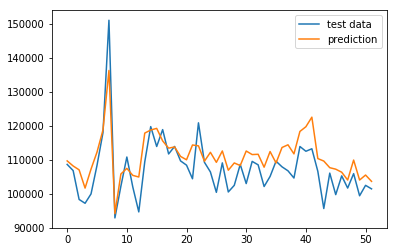

In [38]:
plt.plot(dep2test['weeklySales'],label="test data")
plt.plot(y_pred,label="prediction")
plt.legend(loc='upper right')
plt.show()

* Q3.2 (20%) Repeat Q3.1 but use the original weekly sales instead of the transformed values.

In [39]:
kernel=RBF()+ExpSineSquared()+WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel)
X_train= np.array(dep2train["week"]).reshape(-1, 1)
y_train= np.array(dep2train["weeklySales"])
gp.fit(X_train,y_train)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=RBF(length_scale=1) + ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [40]:
x_test=np.array(dep2test["week"]).reshape(-1,1)
y_pred=gp.predict(x_test)
print(y_pred[:5])

[202.03251053 202.03251033 202.03251013 202.03250991 202.03250969]


In [41]:
y_true=dep2test["weeklySales"]
print(mean_absolute_percentage_error(y_true, y_pred))

0.998106655270989


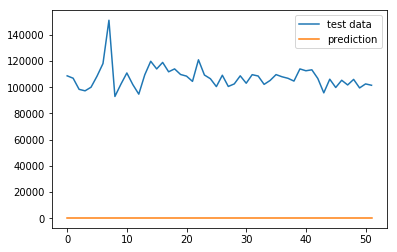

In [42]:
plt.plot(dep2test['weeklySales'],label="test data")
plt.plot(y_pred,label="prediction")
plt.legend(loc='upper right')
plt.show()

* Q3.3 (20%) Selected the best model from Q3.1 and Q3.2. Use this model to perform "Expanding Window" approach and compute MAPE. Note that you do not need to retrain the model when each new test data arrive. 

In [43]:
pred=[]
X= list(dep2train["week"])
y= list(dep2train["NormalizedweeklySales"])
for i in range(len(dep2test)):
    prediction=gp1.predict(np.array(dep2test.iloc[i:i+1,3]).reshape(-1, 1))
    pred.append(prediction[0])
    X.append(dep2test.iloc[i:i+1,3])
    y.append(dep2test.iloc[i:i+1,4])
    gp1.fit(np.array(X).reshape(-1, 1),y)

In [44]:
y_pred=np.array(pred)*std+mean
print(y_pred[:5])

[109691.31571782 108164.01219003 107138.73756671 101474.10100247
 107148.20969915]


In [45]:
y_true=dep2test["weeklySales"]

In [46]:
print(mean_absolute_percentage_error(y_true, y_pred))

0.04456770429257774


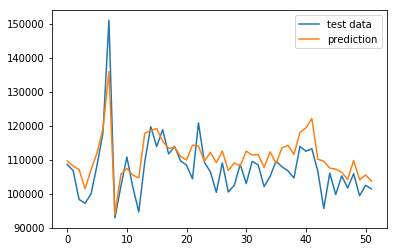

In [47]:
plt.plot(dep2test['weeklySales'],label="test data")
plt.plot(y_pred,label="prediction")
plt.legend(loc='upper right')
plt.show()

### Question 4 [Summarize and Discuss]
(10%) Summarize the prediction performance and discuss your findings. 

# 結果發現
1.高斯過程迴歸若沒有標準化output value y，會產生很差的結果

推測可能原因為:Gaussian processes regression is prone to numerical problems!

2.在使用Random Forest做分析時，若加入去年同期的銷售資料做預測，表現會比較好

這個結果與預期相符，因為去年同期的銷售資料是很重要的資訊，且從Question 1 [Baseline]，我們也得知直接拿去年同期的銷售資料來預測下一年就可以有很好的表現

3.若有標準化output value y，高斯過程迴歸整體表現不錯

推測可能原因是:

Gaussian process (GP) directly captures the model uncertainty.

When using GP, we are able to add prior knowledge and specifications about the shape of the model by selecting different kernel functions!


### Bonus Question 4 [My Prediction Model]
(20%) This is a bonus question. Develop your own method. Your method should be different from the methods in Questions 1 to 3. Moreover, your method should deliver a MAPE that is better than the baseline model. 